In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

from sklearn import datasets 
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer

In [2]:
# read fire data
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT FIRE_YEAR, STAT_CAUSE_DESCR, LATITUDE, LONGITUDE, STATE, COUNTY, FIPS_NAME, DISCOVERY_DATE, CONT_DATE, FIRE_SIZE, DISCOVERY_DOY, DISCOVERY_TIME FROM 'Fires'", conn)
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['END_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
#df.head(5)

In [3]:
# Extract and reformat DATETIME for easy lookup for fire data
df['TIME'] = df['DISCOVERY_TIME'].str[0:2]
df['DATETIME'] = df['DATE'].dt.strftime('%Y-%m-%d') + ' ' +  df['TIME']
#df

In [4]:
# Prune years not in range 2012-2015 for fire data
df = df[df['FIRE_YEAR'] >= 2012]
#df

In [5]:
# Read in Weather Data
# df_fire = pd.read_csv('California_Fire_Incidents.csv')
df_humidity = pd.read_csv('humidity.csv')
df_pressure = pd.read_csv('pressure.csv')
df_temp = pd.read_csv('temperature.csv')
df_weather = pd.read_csv('weather_description.csv')
df_wind_direction = pd.read_csv('wind_direction.csv')
df_wind_speed = pd.read_csv('wind_speed.csv')
df_city_attributes = pd.read_csv('city_attributes.csv')

In [6]:
# Prune Irrelevant Cities
cities = df_humidity.columns.drop(['Jerusalem', 'Haifa', 'Eilat', 'Tel Aviv District', 'Beersheba', 'Nahariyya'])
df_humidity = df_humidity[cities]
df_pressure = df_pressure[cities]
df_temp = df_temp[cities]
df_weather = df_weather[cities]
df_wind_direction = df_wind_direction[cities]
df_wind_speed = df_wind_speed[cities]
# df_city_attributes = df_city_attributes[cities]

In [7]:
# Find all cities common between forest fire data and weather data
common_cities = []
for city in cities:
    if(len(df.loc[df['FIPS_NAME']==city]) != 0):
        common_cities.append(city)

In [8]:
# Prune all cities not common between forest fire data and weather data
df = df[df['FIPS_NAME'].isin(common_cities)]
#df

In [9]:
# Combine and Restructure all weather dataframes into one DataFrame and append a city column
columns = ['time', 'humidity', 'pressure', 'temperature', 'weather', 'wind direction', 'wind speed']
df_weatherdata = pd.DataFrame()
for city in common_cities:
    newdf = pd.DataFrame(pd.concat([df_humidity['datetime'], df_humidity[city], df_pressure[city], df_temp[city], df_weather[city], df_wind_direction[city], df_wind_speed[city]], axis=1, keys=columns))
    newdf['city'] = city
    df_weatherdata = df_weatherdata.append(newdf, ignore_index=True)
#df_weatherdata

In [10]:
# Combine Date and Time for Easy Lookup
df_weatherdata['DATE'] = df_weatherdata['time'].str[0:11]
df_weatherdata['TIME'] = df_weatherdata['time'].str.split(":").str[0].str[11:]
df_weatherdata['DATETIME'] = df_weatherdata['DATE'] + df_weatherdata['TIME']
#print(df_weatherdata['DATETIME'])

In [11]:
# Prune years that arent between 2012-2015
df_weatherdata = df_weatherdata[~(df_weatherdata['DATE'].astype(str).str.contains('2016') | df_weatherdata['DATE'].astype(str).str.contains('2017'))]
#df_weatherdata['DATE']

In [12]:
# Combine DATETIME and Cities for easy lookup for weather data
df_weatherdata['DATETIME_CITY'] = df_weatherdata['DATETIME'] + ' ' + df_weatherdata['city']
#print(df_weatherdata['DATETIME_CITY'])

In [13]:
# Combine DATETIME and Cities for easy lookup for forest fire data
df['DATETIME_CITY'] = df['DATETIME'].astype(str) + ' ' + df['FIPS_NAME']
#print(df['DATETIME_CITY'])

In [14]:
df_weatherdata['FIRE_DAYS'] = False

In [15]:
df_weatherdata['FIRE'] = False

In [16]:
# Create a Fire column to track which datetimes in which cities had fires occur
df_weatherdata['FIRE'][df_weatherdata.loc[df_weatherdata['DATETIME_CITY'].isin(df['DATETIME_CITY'].values)].index] = True
df_weatherdata = df_weatherdata[df_weatherdata.columns.drop(['time', 'DATE', 'TIME', 'DATETIME_CITY'])]
#print(df_weatherdata.loc[df_weatherdata['FIRE']==True])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The above warning is fine, I double checked the data and it actually changes. So that's cool

#### Armin Pre-Processing to hopefully make everything work

In [17]:
df_weatherdata

,humidity,pressure,temperature,weather,wind direction,wind speed,city,DATETIME,FIRE_DAYS,FIRE
0,NaN,NaN,NaN,NaN,NaN,NaN,San Francisco,2012-10-01 12,False,False
1,88.0,1009.0,289.480000,light rain,150.0,2.0,San Francisco,2012-10-01 13,False,False
2,87.0,1009.0,289.474993,sky is clear,147.0,2.0,San Francisco,2012-10-01 14,False,False
3,86.0,1009.0,289.460618,sky is clear,141.0,2.0,San Francisco,2012-10-01 15,False,False
4,85.0,1009.0,289.446243,sky is clear,135.0,2.0,San Francisco,2012-10-01 16,False,False
...,...,...,...,...,...,...,...,...,...,...
345242,66.0,1017.0,281.210000,overcast clouds,290.0,6.0,New York,2015-12-31 19,False,False
345243,66.0,1017.0,281.220000,overcast clouds,310.0,5.0,New York,2015-12-31 20,False,False
345244,64.0,1017.0,281.026831,overcast clouds,307.0,5.0,New York,2015-12-31 21,False,False
345245,61.0,1018.0,280.360000,overcast clouds,300.0,5.0,New York,2015-12-31 22,False,False


In [18]:
df_weatherdata.columns

Index(['humidity', 'pressure', 'temperature', 'weather', 'wind direction',
       'wind speed', 'city', 'DATETIME', 'FIRE_DAYS', 'FIRE'],
      dtype='object')

In [19]:
# before continuing drop any row that contains NaN values in more than one column
df_weatherdata.dropna(subset=['humidity', 'pressure', 'temperature'], how='all', inplace=True)
df_weatherdata.shape

(227800, 10)

In [20]:
# Want to get rid of DATETIME, FIRE_DAYS, and FIRE for now
df_holder = pd.concat([df_weatherdata.pop(x) for x in ['DATETIME', 'FIRE_DAYS', 'FIRE']], axis=1)

In [21]:
df_holder

,DATETIME,FIRE_DAYS,FIRE
1,2012-10-01 13,False,False
2,2012-10-01 14,False,False
3,2012-10-01 15,False,False
4,2012-10-01 16,False,False
5,2012-10-01 17,False,False
...,...,...,...
345242,2015-12-31 19,False,False
345243,2015-12-31 20,False,False
345244,2015-12-31 21,False,False
345245,2015-12-31 22,False,False


In [22]:
df_weatherdata.columns

Index(['humidity', 'pressure', 'temperature', 'weather', 'wind direction',
       'wind speed', 'city'],
      dtype='object')

#### Label Encode City and Weather

In [23]:
# Start Label Encoding weather and city
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_weatherdata['weather'] = le.fit_transform(df_weatherdata['weather'].astype(str))
df_weatherdata['city'] = le.fit_transform(df_weatherdata['city'].astype(str))

In [24]:
# Sanity Check
df_weatherdata['weather']

1         12
2         24
3         24
4         24
5         24
          ..
345242    17
345243    17
345244    17
345245    17
345246    16
Name: weather, Length: 227800, dtype: int64

#### Impute NaN values

In [25]:
# Function to assist with Imputing
from sklearn.experimental import enable_iterative_imputer # required to use IterativeImputer
from sklearn.impute import IterativeImputer # filling nan

# function that will fill in the NaN values using MICE imputation method
def mvImp(df_incomplete):
    # fill the na values with 9999
    df_incomplete = df_incomplete.fillna(9999)
    # create an object of type IterativeImputer from the sklearn class
    imputer = IterativeImputer(missing_values = 9999, max_iter=30, random_state=0,
                 add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean', 
                 max_value=None, min_value=None, 
                 n_nearest_features=None,
                 tol=0.001, verbose=0)
    # fit the object on our incomplete data
    imputer.fit(df_incomplete)
    # transform the data and store into a new variable
    imputedData = imputer.transform(df_incomplete)

    return imputedData

In [26]:
# Impute NaN values in df_weatherdata
df_weatherdata = mvImp(df_weatherdata)

In [27]:
# Convert df_weather data back into pandas dataframe
df_weatherdata = pd.DataFrame(df_weatherdata,columns=['humidity', 'pressure', 'temperature', 'weather', 
                                                      'wind direction', 'wind speed', 'city'])

In [28]:
df_weatherdata = pd.concat([df_weatherdata.reset_index(drop=True),df_holder.reset_index(drop=True)], axis=1)

In [29]:
df_weatherdata

,humidity,pressure,temperature,weather,wind direction,wind speed,city,DATETIME,FIRE_DAYS,FIRE
0,88.0,1009.0,289.480000,12.0,150.0,2.0,7.0,2012-10-01 13,False,False
1,87.0,1009.0,289.474993,24.0,147.0,2.0,7.0,2012-10-01 14,False,False
2,86.0,1009.0,289.460618,24.0,141.0,2.0,7.0,2012-10-01 15,False,False
3,85.0,1009.0,289.446243,24.0,135.0,2.0,7.0,2012-10-01 16,False,False
4,84.0,1009.0,289.431869,24.0,129.0,2.0,7.0,2012-10-01 17,False,False
...,...,...,...,...,...,...,...,...,...,...
227795,66.0,1017.0,281.210000,17.0,290.0,6.0,5.0,2015-12-31 19,False,False
227796,66.0,1017.0,281.220000,17.0,310.0,5.0,5.0,2015-12-31 20,False,False
227797,64.0,1017.0,281.026831,17.0,307.0,5.0,5.0,2015-12-31 21,False,False
227798,61.0,1018.0,280.360000,17.0,300.0,5.0,5.0,2015-12-31 22,False,False


In [30]:
df_weatherdata['HOUR'] = df_weatherdata['DATETIME'].str[11:]
df_weatherdata['DAY'] = df_weatherdata['DATETIME'].str[8:10]
df_weatherdata['MONTH'] = df_weatherdata['DATETIME'].str[5:7]
df_weatherdata['YEAR'] = df_weatherdata['DATETIME'].str[0:4]

# Can drop the DATETIME column as we are encoding it in a way to get more information
del df_weatherdata['DATETIME']

In [31]:
df_weatherdata.columns

Index(['humidity', 'pressure', 'temperature', 'weather', 'wind direction',
       'wind speed', 'city', 'FIRE_DAYS', 'FIRE', 'HOUR', 'DAY', 'MONTH',
       'YEAR'],
      dtype='object')

In [32]:
# Moving up the DATETIME Encoding to make Feature Importance easier
df_weatherdata['HOUR_SIN'] = np.sin(df_weatherdata['HOUR'].astype(float)*(2.*np.pi/24))
df_weatherdata['HOUR_COS'] = np.cos(df_weatherdata['HOUR'].astype(float)*(2.*np.pi/24))
df_weatherdata['DAY_SIN'] = np.sin(df_weatherdata['DAY'].astype(float)*(2.*np.pi/30))
df_weatherdata['DAY_COS'] = np.cos(df_weatherdata['DAY'].astype(float)*(2.*np.pi/30))
df_weatherdata['MONTH_SIN'] = np.sin(df_weatherdata['MONTH'].astype(float)*(2.*np.pi/12))
df_weatherdata['MONTH_COS'] = np.cos(df_weatherdata['MONTH'].astype(float)*(2.*np.pi/12))

In [33]:
df_weatherdata.columns

Index(['humidity', 'pressure', 'temperature', 'weather', 'wind direction',
       'wind speed', 'city', 'FIRE_DAYS', 'FIRE', 'HOUR', 'DAY', 'MONTH',
       'YEAR', 'HOUR_SIN', 'HOUR_COS', 'DAY_SIN', 'DAY_COS', 'MONTH_SIN',
       'MONTH_COS'],
      dtype='object')

#### Some quick methods to look at feature importance:
 - Random Forest Feature Importance 
 - Correlation Matrix

In [34]:
# Feature Importance functions

from sklearn.ensemble import RandomForestClassifier # feature importance

# Function for Random Forest Feature Importance
def rf_feature_importance(dataFrame):
    names = dataFrame.columns
    df_copy = dataFrame.copy()
    Y = df_copy.pop('FIRE')
    X = df_copy
    
    rf = RandomForestClassifier()
    rf.fit(X, Y)
    
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
    
# Function to calculate Pearson correlation heatmap
def pearson_feature_importance(dataFrame, threshold):
    plt.figure(figsize=(12,10))
    cor = dataFrame.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    
    cor_target = abs(cor['FIRE'])
    relevant_features = cor_target[cor_target > threshold]
    print(relevant_features)

In [35]:
df_weatherdata.columns

Index(['humidity', 'pressure', 'temperature', 'weather', 'wind direction',
       'wind speed', 'city', 'FIRE_DAYS', 'FIRE', 'HOUR', 'DAY', 'MONTH',
       'YEAR', 'HOUR_SIN', 'HOUR_COS', 'DAY_SIN', 'DAY_COS', 'MONTH_SIN',
       'MONTH_COS'],
      dtype='object')

In [36]:
# Random Forest
rf_feature_importance(df_weatherdata)

[(0.1582, 'temperature'), (0.111, 'wind direction'), (0.109, 'humidity'), (0.0891, 'pressure'), (0.064, 'HOUR'), (0.0583, 'DAY_SIN'), (0.0559, 'HOUR_COS'), (0.0447, 'FIRE'), (0.0424, 'YEAR'), (0.042, 'HOUR_SIN'), (0.0409, 'weather'), (0.0382, 'wind speed'), (0.0368, 'city'), (0.0292, 'DAY'), (0.0286, 'DAY_COS'), (0.0263, 'MONTH'), (0.0255, 'MONTH_SIN'), (0.0, 'FIRE_DAYS')]


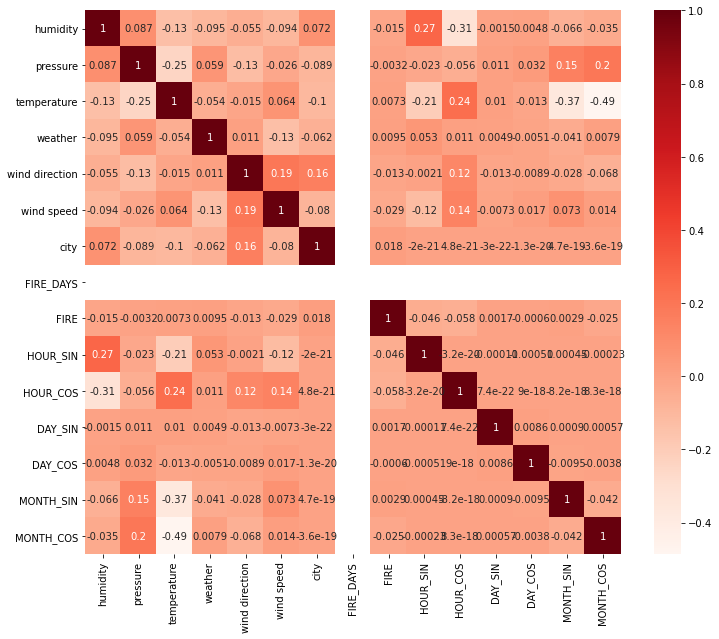

FIRE        1.000000
HOUR_COS    0.057882
Name: FIRE, dtype: float64


In [37]:
# Pearson Correlation
pearson_feature_importance(df_weatherdata, threshold=0.05)

<br>

<br>

# PART 2

In [38]:
X = df_weatherdata[df_weatherdata.columns.drop(['FIRE', 'FIRE_DAYS'])]
y = df_weatherdata['FIRE']

In [39]:
# Easier to label encode y from here
y = le.fit_transform(y)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [42]:
X_train

array([[ 0.33599853, -1.36452165,  0.28250528, ...,  0.41439979,
         1.30456295, -0.78228429],
       [-1.30316738, -1.47691587,  1.20354232, ...,  1.35560703,
         0.77804012, -1.29405949],
       [ 0.54089427,  0.77096851,  1.50582544, ..., -1.30527141,
        -1.37969058, -0.08318637],
       ...,
       [-1.25194345,  1.22054539,  1.00218176, ..., -0.16729827,
        -1.18696984,  0.61591156],
       [-0.22746475, -0.4653679 , -0.4396715 , ...,  0.41439979,
         1.30456295, -0.78228429],
       [ 0.4384464 , -1.13973321,  1.00584497, ...,  1.26473687,
        -1.37969058, -0.08318637]])

#### Oversampling

In [43]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

#### Undersampling

In [44]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_undersampled , y_undersampled = rus.fit_resample(X_train, y_train)

In [45]:
pd.crosstab(index=y_resampled, columns='count')

col_0,count
row_0,
0,151397
1,151397


In [46]:
def fiveCVLogisticRegression(xtrain, ytrain, C_grid):
    scores_train = np.zeros(len(C_grid))
    scores_test = np.zeros(len(C_grid))
    for i in range(5):
        print('Run ', i+1)
        kfold = StratifiedKFold(n_splits=5, shuffle=True)
        
        model = LogisticRegression(penalty='l2')

        grid = {"C":C_grid, "penalty":["l2"]} # l2 ridge
        logreg = LogisticRegression()
        logreg_cv = GridSearchCV(logreg, grid, cv=kfold, return_train_score=True)
        logreg_cv.fit(xtrain, ytrain)

        # View the accuracy score
        # print('Best score for training data:', logreg_cv.best_score_,"\n") 

        # View the best parameters for the model found using grid search
        print('Best lambda:', 1.0/logreg_cv.best_estimator_.C,"\n") 


        # print("Training set score for logreg_cv: ",  logreg_cv.cv_results_['mean_train_score'])
        # print("Testing  set score for logreg_cv: ", logreg_cv.cv_results_['mean_test_score'])

        scores_train += logreg_cv.cv_results_['mean_train_score']
        scores_test += logreg_cv.cv_results_['mean_test_score']

    scores_train = scores_train/5
    scores_test = scores_test/5
   

    print('avg train score: ', scores_train)
    print('avg test score: ', scores_test)
    return scores_train, scores_test

In [90]:
C_grid = [1e-3, 1e-2, 1e-1, 1, 1e1, 50.0, 1e2, 1e3]
scores_train_std, scores_test_std = fiveCVLogisticRegression(X_resampled, y_resampled, C_grid)

Run  1
Best lambda: 10.0 

Run  2
Best lambda: 10.0 

Run  3
Best lambda: 100.0 

Run  4
Best lambda: 1.0 

Run  5
Best lambda: 1.0 

avg train score:  [0.74240639 0.74252462 0.74254411 0.74254609 0.74254691 0.74254625
 0.74254625 0.74254642]
avg test score:  [0.74238129 0.74251141 0.74252528 0.7425233  0.7425233  0.7425233
 0.7425233  0.7425233 ]


In [107]:
def CVLogisticRegression(xtrain, ytrain, xtest, ytest, _lambda):
    model = LogisticRegression(penalty='l2', C=1/_lambda)
    model.fit(xtrain, ytrain)

    train_score = 1 - model.score(xtrain, ytrain)
    test_score = 1 - model.score(xtest, ytest)


    return train_score, test_score

In [108]:
avg_train_error, avg_test_error = CVLogisticRegression(X_resampled, y_resampled, X_test, y_test, 100)

In [109]:
table = {'Method': ['std'], 
        #  'lambda': [best_lambda_std, best_lambda_log, best_lambda_bin], 
        #  'Avg Val Error': [avg_val_error_std, avg_val_error_log, avg_val_error_bin], 
         'Train Error': [avg_train_error], 
        'Test Error': [avg_test_error]}
df_table = pd.DataFrame(table)

In [110]:
df_table

,Method,Train Error,Test Error
0,std,0.257472,0.319046


## Testing Out AdaBoost and RandomForest Variations

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [59]:
# Best AdaBoost
adaBoost = AdaBoostClassifier(learning_rate=0.8, n_estimators=300)
randomForest = RandomForestClassifier(n_estimators=400, max_depth=20)

In [49]:
# fit adaboost
adaBoost.fit(X_undersampled, y_undersampled)
print(f'AdaBoost test score: {adaBoost.score(X_test, y_test)}')

AdaBoostClassifier(learning_rate=0.8, n_estimators=300)

In [60]:
# fit randomforest
randomForest.fit(X_resampled, y_resampled)
print(f'RandomForest test score: {randomForest.score(X_test, y_test)}')

RandomForest test score: 0.5504695772474526


<br>

In [47]:
# Function that uses 5 kFold CV to find best features from input grid
def fiveCVBestParameters(X_train, y_train, X_test, y_test, input_grid, model):
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    grid_cv = GridSearchCV(model, input_grid, cv=kfold, return_train_score=True)

    grid_cv.fit(X_train, y_train)

    print(f'Best Parameters: {grid_cv.best_params_}')
    print(f'Best Score: {grid_cv.best_score_}')
    print(f'Best Model Test Score: {grid_cv.best_estimator_.score(X_test, y_test)} \n')

In [49]:
# Construct Grids to use to search for features
adaboost_grid = {'n_estimators': [50, 80, 100, 200, 300],
                 'learning_rate':[0.01, 0.1, 0.5, 0.8]}
randomforest_grid = {'n_estimators':[100, 200, 400, 500, 1000, 2000],
                      'max_depth': [20, 40, 60, 80, 100, None]}
svm_grid = {'gamma':[1,0.1,0.001,0.0001],
            'C': [1, 10, 100, 1000]}

# AdaBoost
adaBoost = AdaBoostClassifier()
print('Finding best parameters for AdaBoost...')
fiveCVBestParameters(X_undersampled, y_undersampled, X_test, y_test, adaboost_grid, adaBoost)

# RandomForest
randomForest = RandomForestClassifier()
print('Finding best parameters for RandomForest...')
fiveCVBestParameters(X_undersampled, y_undersampled, X_test, y_test, randomforest_grid, randomForest)

# Support Vector Machine
svm = SVC()
print('Finding best parameters for SupportVectorMachine...')
fiveCVBestParameters(X_undersampled, y_undersampled, X_test, y_test, svm_grid, svm)

Finding best parameters for AdaBoost...
Best Parameters: {'learning_rate': 0.5, 'n_estimators': 80}
Best Score: 0.7725729803122879
Best Model Test Score: 0.7150078484582435 

Finding best parameters for RandomForest...
Best Parameters: {'max_depth': None, 'n_estimators': 500}
Best Score: 0.7799033000513305
Best Model Test Score: 0.7127065208715779 

Finding best parameters for SupportVectorMachine...
Best Parameters: {'C': 1, 'gamma': 0.1}
Best Score: 0.7380044044839633
Best Model Test Score: 0.6846383057972171 



### Keep Testing